# NLP Project : Disaster Tweets

This notebook will document our NLP learning process.

---

### *Goal*

**Here, we are predicting whether a given tweet is about a real disaster or not. This is a binary classification problem.**


### *Data*

- train.csv : the training set
- test.csv : the test set
- sample_submission.csv : a sample submission example


## *Columns*

* *id* : a unique identifier for each tweet
* *text* : the text of the tweet
* *location* : the location the tweet was sent from (may be blank)
* *keyword* : a particular keyword from the tweet (may be blank)
* *target* : in train.csv only, this denotes whether a tweet is about a real disaster (1) or not (0)

---

## References

- https://www.kaggle.com/gunesevitan/nlp-with-disaster-tweets-eda-cleaning-and-bert
- https://www.kaggle.com/faressayah/natural-language-processing-nlp-for-beginners
- https://www.kaggle.com/pavansanagapati/knowledge-graph-nlp-tutorial-bert-spacy-nltk/notebook
- https://www.kaggle.com/shahules/basic-eda-cleaning-and-glove
- https://www.kaggle.com/frankmollard/nlp-a-gentle-introduction-lstm-word2vec-bert
---

## Libraries import

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
from wordcloud import WordCloud

import missingno as msno

from tqdm import tqdm

# Nltk libraries
import nltk
from nltk import ngrams

import re
import string

from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer, HashingVectorizer
from sklearn.pipeline import Pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import SGDClassifier
from sklearn import svm

from sklearn.metrics import accuracy_score, f1_score, confusion_matrix, classification_report


## Load data

 ### Train dataset

In [2]:
df_train = pd.read_csv(r'C:\Users\straw\Desktop\AIS2\DisasterTweets\Data\train.csv')
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [3]:
df_train.duplicated().sum()

0

### Test dataset

In [4]:
df_test = pd.read_csv(r'C:\Users\straw\Desktop\AIS2\DisasterTweets\Data\test.csv')
df_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [5]:
df_test.duplicated().sum()

0

Target values are not avaible in Kaggle's test set. 

> **Gunes Evitan ([@gunesevitan](https://www.kaggle.com/gunesevitan)) wrote:**
> Test set labels can be found on [this](https://www.figure-eight.com/data-for-everyone/) website. Dataset is named **Disasters on social media**. This is how people are submitting perfect scores. Other "Getting Started" competitions also have their test labels available. The main point of "Getting Started" competitions is **learning and sharing**, and perfect score doesn't mean anything. 
> According to [@philculliton](https://www.kaggle.com/philculliton) from Kaggle Team, competitors who use test set labels in any way are not eligible to win AutoML prize. There are no other penalties for using them.


In [6]:
df_leak = pd.read_csv(r'C:\Users\straw\Desktop\AIS2\DisasterTweets\Data\socialmedia-disaster-tweets-DFE.csv', encoding ='ISO-8859-1')[["choose_one", "text"]]

df_leak['target'] = (df_leak['choose_one'] == 'Relevant').astype(np.int8)
df_leak.drop(columns=['choose_one'], inplace=True)

df_test = df_test.merge(df_leak, on=['text'])
df_test.head()

,id,keyword,location,text,target
0,0,NaN,NaN,Just happened a terrible car crash,1
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",1
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",1
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,1
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,1


In [7]:
df_train.location = df_train.location.fillna('unknown-location')
df_train.keyword = df_train.keyword.fillna('Unknown-keyword')
df_test.location = df_test.location.fillna('unknown-location')
df_test.keyword = df_test.keyword.fillna('Unknown-keyword')

In [8]:
def remove_stopwords(sent):
    stopW = nltk.corpus.stopwords.words('english')
    stopW.extend(list(string.punctuation))
    return [word for word in sent if word not in stopW]

def lemmatize(sent, join=False):
    lemmatizer = nltk.stem.WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(lemmatizer.lemmatize(lemmatizer.lemmatize(w,'v'),'n'),'a') for w in sent]
    if join:
        return ' '.join(tokens)
    else:
        return tokens
    
def remove_digits(sent):
    return [word for word in sent if not re.match(r"\S*\d+\S*", word)]

def remove_single_letters(sent):
    return [word for word in sent if len(word) > 1]

def remove_noise(sent):
    typos = ["û_", "amp", "ûª", "http", "https", "co", "rt", 
             "ûªs", "@", "...", "ûªs", "ûò", "åè", "ìñ1"]
    return [word for word in sent if word not in typos]

def join_tweets(sent):
    return "  ".join(sent)

def preprocess(df):
    # Normalize
    df['text_cleaned'] = df['text'].apply(lambda sent: sent.lower())
    
    # Tokenize
    token = nltk.tokenize.RegexpTokenizer(r"\w+")
    df['text_cleaned'] = df['text_cleaned'].apply(token.tokenize)
    
    # New column : tweet lengths before cleaning
    df['text_length_before'] = df.text_cleaned.apply(len)
    
    # Remove stopwords and punctuation
    df['text_cleaned'] = df['text_cleaned'].apply(lambda sent: remove_stopwords(sent)).reset_index(drop=True)
    
    # Lemmatize
    df['text_cleaned'] = df['text_cleaned'].apply(lambda sent: lemmatize(sent))
    
    # Remove digits
    df['text_cleaned'] = df['text_cleaned'].apply(remove_digits).reset_index(drop=True)
    
    # Remove single letter
    df['text_cleaned'] = df['text_cleaned'].apply(remove_single_letters).reset_index(drop=True)
    
    # Remove weird symbols
    df['text_cleaned'] = df['text_cleaned'].apply(remove_noise).reset_index(drop=True)
    
    # New column : tweet lengths after cleaning
    df['text_length_after'] = df.text_cleaned.apply(len)
    
    # Join words into one str
    df['text_cleaned'] = df['text_cleaned'].apply(join_tweets)
    
    return df

In [9]:
df_train = preprocess(df_train)
df_test = preprocess(df_test)

## Wordcloud

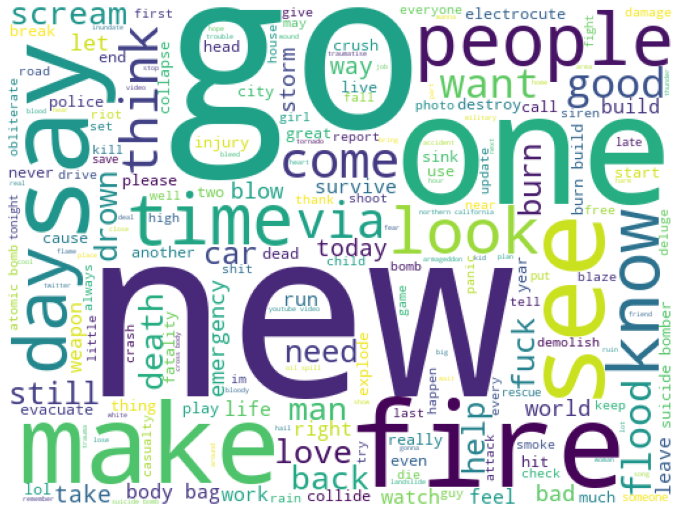

In [10]:
texts = []
for i in range(0, df_train.shape[0]):
    texts.append(df_train['text_cleaned'][i])

plt.subplots(figsize=(12,12))
wordcloud = WordCloud(
                        background_color='white',
                        width=512,
                        height=384
                        ).generate(" ".join(texts))
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

## Splitting data

In [11]:
X = np.array(df_train.text_cleaned)
y = np.array(df_train.target)

X_train, X_val, y_train, y_val = train_test_split(X, y, stratify=y, shuffle=True, test_size=0.25)

In [12]:
X_test = np.array(df_test.text_cleaned)
y_test = np.array(df_test.target)

## Vectorization

In [13]:
vect = CountVectorizer()

vect.fit(X_train)
X_train_dtm = vect.transform(X_train)
X_val_dtm = vect.transform(X_val)
X_test_dtm = vect.transform(X_test)

In [14]:
tfidf_transformer = TfidfTransformer()
tfidf_transformer.fit_transform(X_train_dtm)
tfidf_transformer.transform(X_val_dtm)
tfidf_transformer.transform(X_test_dtm)

<3477x11671 sparse matrix of type '<class 'numpy.float64'>'
	with 26017 stored elements in Compressed Sparse Row format>

## Classification with Machine Learning

In [15]:
clf = LogisticRegression()

In [16]:
%time clf.fit(X_train_dtm, y_train)

Wall time: 149 ms


LogisticRegression()

### Validation set

In [17]:
%time y_pred_val = clf.predict(X_val_dtm)

Wall time: 996 µs


In [18]:
accuracy_score(y_val, y_pred_val)

0.7956932773109243

In [19]:
f1_score(y_val, y_pred_val)

0.7442472057856674

<AxesSubplot:>

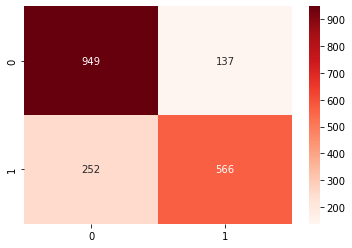

In [20]:
sns.heatmap(confusion_matrix(y_val, y_pred_val), annot=True, fmt='.4g', cmap='Reds')

In [21]:
print(classification_report(y_val, y_pred_val))

              precision    recall  f1-score   support

           0       0.79      0.87      0.83      1086
           1       0.81      0.69      0.74       818

    accuracy                           0.80      1904
   macro avg       0.80      0.78      0.79      1904
weighted avg       0.80      0.80      0.79      1904



### Test set

In [22]:
%time y_pred_test = clf.predict(X_test_dtm)

Wall time: 1.96 ms


In [23]:
accuracy_score(y_test, y_pred_test)

0.7937877480586712

In [24]:
f1_score(y_test, y_pred_test)

0.7523316062176166

<AxesSubplot:>

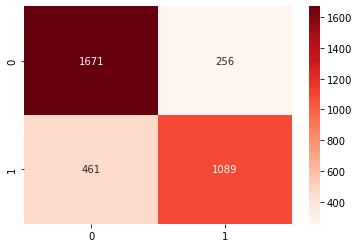

In [25]:
sns.heatmap(confusion_matrix(y_test, y_pred_test), annot=True, fmt='.4g', cmap='Reds')

In [26]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      1927
           1       0.81      0.70      0.75      1550

    accuracy                           0.79      3477
   macro avg       0.80      0.78      0.79      3477
weighted avg       0.80      0.79      0.79      3477



In [27]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint

import transformers
from tqdm.notebook import tqdm
from tokenizers import BertWordPieceTokenizer

In [28]:
!pip install transformers

In [29]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained('bert-large-uncased')

def bert_encode(data, maximum_length) :
    input_ids = []
    attention_masks = []

    for text in data:
        encoded = tokenizer.encode_plus(
            text, 
            add_special_tokens=True,
            max_length=maximum_length,
            padding=True,
            truncation=True,
            return_attention_mask=True,
        )
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)

In [30]:
texts = df_train['text_cleaned']
target = df_train['target']

train_input_ids, train_attention_masks = bert_encode(texts, 60)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\straw\anaconda3\lib\site-packages\transformers\tokenization_utils_base.py:2221: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [31]:
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

def create_model(bert_model):
    
    input_ids = tf.keras.Input(shape=(60,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(60,), dtype='int32')

    output = bert_model([input_ids, attention_masks])
    output = output[1]
    output = tf.keras.layers.Dense(32, activation='relu')(output)
    output = tf.keras.layers.Dropout(0.2)(output)
    output = tf.keras.layers.Dense(1, activation='sigmoid')(output)
    
    model = tf.keras.models.Model(inputs = [input_ids, attention_masks], outputs = output)
    model.compile(Adam(lr=1e-5), loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [32]:
from transformers import TFBertModel
bert_model = TFBertModel.from_pretrained('bert-base-uncased')

Downloading:   0%|          | 0.00/511M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-uncased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-uncased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [33]:
model = create_model(bert_model)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 60)]         0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_1[0][0]',                
                                thPoolingAndCrossAt               'input_2[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 60,                                            

C:\Users\straw\anaconda3\lib\site-packages\keras\optimizer_v2\adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
history = model.fit(
    [train_input_ids, train_attention_masks],
    target,
    validation_split=0.2, 
    epochs=3,
    batch_size=10
)

Epoch 1/3
609/609 [==============================] - 2756s 5s/step - loss: 0.5015 - accuracy: 0.7759 - val_loss: 0.4572 - val_accuracy: 0.8109
Epoch 2/3
492/609 [=======================>......] - ETA: 8:27 - loss: 0.3891 - accuracy: 0.8467